# Gradient descent hyperparameter search
Created 08/05/2024

Objectives:
* Use hyperparameter search to find hyperparameters, struggling to get convergence in [this notebook](gradient_descent.ipynb).

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../")

In [80]:
from functools import reduce
from operator import mul
from collections import namedtuple

import time
import pickle

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [56]:
import numpy as np
import pandas as pd

rng = np.random.default_rng()
import matplotlib.pyplot as plt

import scipy

In [6]:
import re

In [7]:
from SPTOptimization.utils import (
    get_right_identity_environment_from_tp_tensor,
    get_left_identity_environment_from_tp_tensor,
    to_npc_array,
    get_physical_dim
)

from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

# Load data

In [10]:
DATA_DIR_1 = r"../data/interpolated_trivial_to_nontrivial_fermionic_trivial_proj_rep_200_site_dmrg/"
DATA_DIR_2 = r"../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [11]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [12]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

In [27]:
psi = loaded_data_non_triv_proj_rep[0.45]

# Definitons

In [15]:
MAX_VIRTUAL_BOND_DIM = 30
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM
# MPO bond dim?
MAX_MPO_BOND_DIM = 50

SVD_CUTOFF = 1e-3

Define bosonic symmetries. Label by the group element added.

In [16]:
np_00 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

np_01 = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

np_11 = np.array([
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0]
])

In [17]:
bosonic_np_symmetries = [
    np_00,
    np_01,
    np_10,
    np_11
]

In [18]:
bosonic_npc_symmetries = [
    to_npc_array(X) for X in bosonic_np_symmetries
]

In [19]:
npc_00 = to_npc_array(np_00)
npc_01 = to_npc_array(np_01)
npc_10 = to_npc_array(np_10)
npc_11 = to_npc_array(np_11)

Define "fermionic symmetries". Just identity and JW string.

In [20]:
np_I = np.array([
    [1, 0],
    [0, 1]
])

np_JW = np.array([
    [1, 0],
    [0, -1]
])

In [21]:
fermionic_np_symmetries = [np_I, np_JW]

In [22]:
fermionic_npc_symmetries = [
    to_npc_array(X) for X in fermionic_np_symmetries
]

In [23]:
npc_JW = fermionic_npc_symmetries[1]

In [24]:
symmetry_actions = [
    [[b, f] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [25]:
shifted_symmetry_actions = [
    [[f, b] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [28]:
s = symmetry_actions[0][1]

case = SymmetryActionWithBoundaryUnitaries(
    psi,
    s*40,
    left_symmetry_index=60,
    left_boundary_unitaries=[np_I, np_00]*1,
    right_boundary_unitaries=[np_00, np_I]*1
)

In [29]:
case.compute_svd_approximate_expectation()

(-7.171141509766298e-28-4.647688751856734e-31j)

## Functions

In [30]:
def get_physical_dim(tensor, p_label='p'):
    index = tensor.get_leg_index(p_label)
    dim = tensor.shape[index]
    return dim

In [31]:
def mpo_frobenius_inner_product(mpo1_tensors, mpo2_tensors=None):
    if mpo2_tensors is None:
        mpo2_tensors = mpo1_tensors

    w1 = mpo1_tensors[0]
    dim = get_physical_dim(w1, p_label='p')
    w2 = mpo2_tensors[0]

    t = npc.tensordot(w1, w2.conj(), [['p', 'p*'], ['p*', 'p']])
    #t /= dim

    for w1, w2 in zip(mpo1_tensors[1:], mpo2_tensors[1:]):
        dim = get_physical_dim(w1, p_label='p')

        t = npc.tensordot(t, w1, [['vR', ], ['vL']])
        t = npc.tensordot(t, w2.conj(), [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']])
        #t /= dim

    return t

In [32]:
def unitary_order_two_right_tensors(w_tensors):
    out = list()

    w = w_tensors[-1]
    t = npc.tensordot(w, w.conj(), [['p', 'p*'], ['p*', 'p']])

    out.append(t)

    for w in w_tensors[-2:0:-1]:
        t = npc.tensordot(t, w, [['vL',], ['vR']])
        t = npc.tensordot(t, w.conj(), [['vL*', 'p', 'p*'], ['vR*', 'p*', 'p']])

        out.append(t)

    return out[::-1]

In [33]:
def unitary_order_four_right_tensors(w_tensors):
    out = list()

    w = w_tensors[-1]
    t = npc.tensordot(w, w.conj(), [['p',], ['p*',]])
    t.ireplace_labels(['vL', 'vL*'], ['vL1', 'vL1*'])
    t = npc.tensordot(t, w, [['p',], ['p*',]])
    t = npc.tensordot(t, w.conj(), [['p', 'p*'], ['p*', 'p']])
    
    out.append(t)

    for w in w_tensors[-2:0:-1]:
        t = npc.tensordot(t, w, [['vL',], ['vR',]])
        t = npc.tensordot(t, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])

        w = w.replace_label('vL', 'vL1')
    
        t = npc.tensordot(t, w, [['vL1', 'p',], ['vR', 'p*']])
        t = npc.tensordot(t, w.conj(), [['vL1*', 'p', 'p*'], ['vR*', 'p*', 'p']])

        out.append(t)

    return out[::-1]

In [34]:
def overlap_right_tensors(w_tensors, b_tensors):
    out = list()

    t = get_right_identity_environment_from_tp_tensor(b_tensors[-1])

    out.append(t)

    # First site
    b = b_tensors[-1]
    w = w_tensors[-1]
    
    t = npc.tensordot(t, b, [['vL',], ['vR',]])
    t = npc.tensordot(
        t,
        w.replace_label('vL', 'vLm'),
        [['p',], ['p*',]]
    )
    t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*',]])

    out.append(t)

    # Inner sites
    for w, b in zip(w_tensors[-2:0:-1], b_tensors[-2:0:-1]):
        t = npc.tensordot(t, b, [['vL',], ['vR',]])
        t = npc.tensordot(
            t,
            w.replace_label('vL', 'vLm'),
            [['p', 'vLm'], ['p*', 'vR']]
        )
        t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*',]])
    
        out.append(t)

    # Last site
    b = b_tensors[0]
    w = w_tensors[0]

    t = npc.tensordot(t, b, [['vL',], ['vR',]])
    t = npc.tensordot(
        t,
        w,
        [['p', 'vLm'], ['p*', 'vR']]
    )
    t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*',]])

    out.append(t)

    return out[::-1]

### Initialize tensors

In [35]:
def rescale_mpo_tensors(mpo_tensors, new_norm):
    num_sites = len(mpo_tensors)

    old_norm = mpo_frobenius_inner_product(mpo_tensors).real
    
    scale_factor = np.power(
        new_norm/old_norm,
        1/(2*num_sites)
    )

    for i in range(num_sites):
        mpo_tensors[i] = scale_factor*mpo_tensors[i]

In [36]:
def generate_random_w_tensor(physical_dim, left_virtual_dim=None,
                             right_virtual_dim=None):

    if (left_virtual_dim is None) and (right_virtual_dim is None):
        dims = (physical_dim, physical_dim)
    elif (left_virtual_dim is None):
        dims = (physical_dim, physical_dim, right_virtual_dim)
    elif (right_virtual_dim is None):
        dims = (physical_dim, physical_dim, left_virtual_dim)
    else: 
        dims = (
            physical_dim,
            physical_dim,
            left_virtual_dim,
            right_virtual_dim
        )
    
    X1 = rng.normal(size=dims)
    X2 = 1j*rng.normal(size=dims)
    X = X1 + X2

        
    if (left_virtual_dim is None) and (right_virtual_dim is None):
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*'])
    elif right_virtual_dim is None:
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*', 'vL'])
    elif left_virtual_dim is None:
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*', 'vR'])
    else:
        out = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL', 'vR']
        )

    return out

In [37]:
def get_random_mpo_tensors(num_sites, norm=None):
    """
    Needs more arguments
    """

    w = generate_random_w_tensor(edge_dims)
    w_tensor = npc.Array.from_ndarray_trivial(
        w,
        labels=['p', 'p*', 'vR']
    )

    w_tensors = [w_tensor,]

    for _ in range(num_sites-2):
        w = generate_random_w_tensor(inner_dims)
        w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL', 'vR'])
        
        w_tensors.append(w_tensor)

    w = generate_random_w_tensor(edge_dims)
    w_tensor = npc.Array.from_ndarray_trivial(
        w,
        labels=['p', 'p*', 'vL']
    )
    w_tensors.append(w_tensor)

    if norm is not None:
        rescale_mpo_tensors(w_tensors, norm)

    return w_tensors

In [38]:
def get_identity_w_tensor(physical_dim, left_virtual_dim=None, right_virtual_dim=None):
    diagonal = np.ones(physical_dim, dtype='complex')
    identity_matrix = np.diag(diagonal)
    
    if (left_virtual_dim is None) and (right_virtual_dim is None):
        w_tensor = npc.Array.from_ndarray_trivial(
            identity_matrix,
            labels=['p', 'p*']
        )
    elif right_virtual_dim is None:
        X = np.zeros(
            (physical_dim, physical_dim, left_virtual_dim),
            dtype='complex'
        )
        X[...,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL']
        )
    elif left_virtual_dim is None:
        X = np.zeros(
            (physical_dim, physical_dim, right_virtual_dim),
            dtype='complex'
        )
        X[...,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vR']
        )
    else:
        X = np.zeros(
            (physical_dim, physical_dim, left_virtual_dim, right_virtual_dim),
            dtype='complex'
        )
        X[...,0,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL', 'vR']
        )

    return w_tensor

In [39]:
def get_random_mpo_tensors(physical_dims, virtual_dims):
    """
    Could fold in with get_identity_mpo_tensors
    """

    w_tensors = [
        generate_random_w_tensor(p_dim, *v_dims)
        for p_dim, v_dims in zip(physical_dims, virtual_dims)
    ]

    return w_tensors

In [40]:
def get_identity_mpo_tensors(physical_dims, virtual_dims):
    """
    Needs more comments, docs!

    Often physical dims, virtual dims will be the same, so could add
    optional behaviour...
    """

    w_tensors = [
        get_identity_w_tensor(p_dim, *v_dims)
        for p_dim, v_dims in zip(physical_dims, virtual_dims)
    ]

    return w_tensors

### ADAM functions

In [41]:
def squared_components(X):
    r, i = (X.real, X.imag)
    return r**2 + 1j*(i**2)

In [42]:
def square_root_components(X):
    r, i = (X.real, X.imag)
    return np.sqrt(r) + 1j*np.sqrt(i)

In [43]:
class AdamTenpy:
    def __init__(self, alpha=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
        self.alpha = alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon

        self.moment_1 = None
        self.moment_2 = None

    def update(self, grad):
        if self.moment_1 is None:
            self.moment_1 = (1-self.beta_1)*grad
        else:
            self.moment_1 = self.beta_1*self.moment_1 + (1-self.beta_1)*grad

        grad_squared = grad.unary_blockwise(squared_components)
        if self.moment_2 is None:
            self.moment_2 = (1-self.beta_2)*grad_squared
        else:
            self.moment_2 = self.beta_2*self.moment_2 + (1-self.beta_2)*grad_squared

        self.moment_1 /= (1-self.beta_1)
        self.moment_2 /= (1-self.beta_2)

        out_grad_denom = (
            self.moment_2
            .unary_blockwise(square_root_components)
            .unary_blockwise(lambda x: x + (1+1j)*self.epsilon)
        )

        out_grad = (
            self.moment_1
            .binary_blockwise(np.divide, out_grad_denom)
        )

        return self.alpha*out_grad

### Sweep function

In [44]:
def mpo_tensor_raw_to_gradient(raw_mpo_tensor, gradient_target_tensor):
    """
    Update raw_mpo_tensor calculated to be the gradient by changing leg names
    as neeeded so can be easily and consistently added to
    gradient_target_tensor.
    """
    leg_labels = raw_mpo_tensor.get_leg_labels()

    # First update the virtual legs
    old_new_leg_label_pairs = [
        ('vL*', 'vR'),
        ('vR*', 'vL'),
        ('vL1*', 'vR'),
        ('vR1*', 'vL'),
        ('vLm', 'vR'),
        ('vRm', 'vL'),
    ]

    for old, new in old_new_leg_label_pairs:
        if old in leg_labels:
            raw_mpo_tensor.ireplace_label(old, new)

    # Then create new array to get the physical legs correct.
    # Is this consistent? Should set order of leg labels on raw_mpo_tensor
    # before casting to array?
    out = npc.Array.from_ndarray_trivial(
        raw_mpo_tensor.to_ndarray(),
        labels=raw_mpo_tensor.get_leg_labels()
    )

    out.itranspose(gradient_target_tensor.get_leg_labels())

    return out

In [45]:
def update_mpo_score(raw_gradient_mpo_tensor, gradient_target_tensor,
                     virtual_legs=[['vL*', 'vR*',], ['vR*', 'vL*',]],
                     take_abs=False
                    ):
    # Calculate "score" (just the contraction of the two relevant tensors)
    raw_legs, target_legs = virtual_legs

    score = npc.tensordot(
        raw_gradient_mpo_tensor,
        gradient_target_tensor.conj(),
        [['p', 'p*', *raw_legs], ['p*', 'p', *target_legs]]
    )

    if take_abs:
        real_score = np.abs(score)
    else:
        real_score = score.real

    return score

In [46]:
def mpo_gradient_descent_sweep(mpo_tensors, b_tensors, total_dimension,
    right_overlap_tensors, unitarity_learning_rate, overlap_learning_rate,
    overlap_target, left_environment, adam_optimizers):
    """
    Really need to tidy this function up...

    Also get matrix_dim directly from tensors.
    """
    # Initialise list of gradients to be filled
    grads = list()

    # Initialise variables
    right_unitary_two_tensors = unitary_order_two_right_tensors(mpo_tensors)
    right_unitary_four_tensors = unitary_order_four_right_tensors(mpo_tensors)
    
    left_unitary_two_tensors = list()
    left_unitary_four_tensors = list()
    left_overlap_tensors = list()

    num_sites = len(mpo_tensors)
    assert len(mpo_tensors) == len(b_tensors)

    # Leftmost site
    w = mpo_tensors[0]
    b = b_tensors[0]

    t = right_unitary_two_tensors[0]

    # Second order terms
    grad_2 = npc.tensordot(t, w, [['vL'], ['vR',]])

    order_2_score = update_mpo_score(
        grad_2,
        w,
        [['vL*',], ['vR*',]]
    )

    grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

    # Fourth order terms
    t = right_unitary_four_tensors[0]

    grad_4 = npc.tensordot(t, w, [['vL'], ['vR',]])
    grad_4 = npc.tensordot(grad_4, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])
    grad_4 = npc.tensordot(grad_4, w, [['vL1', 'p'], ['vR', 'p*']])

    order_4_score = update_mpo_score(
        grad_4,
        w,
        [['vL1*',], ['vR*',]]
    )

    grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)

    unitary_score = order_4_score - 2*order_2_score + total_dimension
    unitary_grad = (grad_4 - grad_2)/np.sqrt(1+unitary_score)
    
    # Overlap terms
    t = right_overlap_tensors[0].conj().replace_label('vLm*', 'vLm')

    grad_o = npc.tensordot(t, b, [['vL'], ['vR',]])
    grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
    grad_o = npc.tensordot(grad_o, left_environment, [['vL', 'vL*'], ['vR', 'vR*']])

    c_conj = update_mpo_score(
        grad_o,
        w,
        [['vLm',], ['vR*',]],
        take_abs=True
    )
    c = c_conj.conjugate()
    c_abs = np.abs(c)
    
    grad_o_scale = c*(1 - overlap_target/c_abs)
    grad_o = grad_o_scale*grad_o
    grad_o = mpo_tensor_raw_to_gradient(grad_o, w)

    grad = (
        unitarity_learning_rate*unitary_grad +
        overlap_learning_rate*grad_o
    )
    adam_grad = adam_optimizers[0].update(grad)
    grads.append(adam_grad)

    # Create and save left tensors
    t = npc.tensordot(w, w.conj(), [['p', 'p*'], ['p*', 'p']])
    left_unitary_two_tensors.append(t)
    
    t = npc.tensordot(w, w.conj(), [['p',], ['p*',]])
    t.ireplace_labels(['vR', 'vR*'], ['vR1', 'vR1*'])
    t = npc.tensordot(t, w, [['p',], ['p*',]])
    t = npc.tensordot(t, w.conj(), [['p', 'p*'], ['p*', 'p']])
    
    left_unitary_four_tensors.append(t)

    t = npc.tensordot(b, w.conj(), [['p',], ['p*',]])
    #print(t)
    t.ireplace_label('vR*', 'vRm')
    #print(t)
    t = npc.tensordot(t, left_environment, [['vL',], ['vR',]])
    #print(t)
    t = npc.tensordot(t, b.conj(), [['vR*', 'p'], ['vL*', 'p*']])

    #print(t)

    left_overlap_tensors.append(t)

    # Inner sites
    for i in range(1, num_sites-1):
        w = mpo_tensors[i]
        b = b_tensors[i]
    
        right_two_tensor = right_unitary_two_tensors[i]
        right_four_tensor = right_unitary_four_tensors[i]
        right_overlap_tensor = right_overlap_tensors[i].conj().replace_label('vLm*', 'vLm')

        # Order two terms
        left_two_tensor = left_unitary_two_tensors[-1]

        grad_2 = npc.tensordot(right_two_tensor, w, [['vL'], ['vR',]])
        grad_2 = npc.tensordot(grad_2, left_two_tensor, [['vL'], ['vR',]])

        grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

        # Order four terms
        left_four_tensor = left_unitary_four_tensors[-1]

        grad_4 = npc.tensordot(right_four_tensor, w, [['vL'], ['vR',]])
        grad_4 = npc.tensordot(grad_4, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])

        grad_4 = npc.tensordot(
            grad_4,
            w.replace_label('vL', 'vL1'),
            [['vL1', 'p'], ['vR', 'p*']]
        )

        grad_4 = npc.tensordot(
            grad_4,
            left_four_tensor,
            [['vL', 'vL*', 'vL1'], ['vR', 'vR*', 'vR1']]
        )

        grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)

        unitary_grad = (grad_4 - grad_2)/np.sqrt(1+unitary_score)
    
        # Overlap terms
        left_overlap_tensor = left_overlap_tensors[-1]

        grad_o = npc.tensordot(right_overlap_tensor, b, [['vL',], ['vR',]])
        grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
        grad_o = npc.tensordot(
            grad_o,
            left_overlap_tensor,
            [['vL*', 'vL'], ['vR', 'vR*',]]
        )

        grad_o = grad_o_scale*grad_o
        grad_o = mpo_tensor_raw_to_gradient(grad_o, w)

        grad = (
            unitarity_learning_rate*unitary_grad +
            overlap_learning_rate*grad_o
        )
        adam_grad = adam_optimizers[i].update(grad)
        grads.append(adam_grad)

        # Update left tensors
        t = npc.tensordot(left_two_tensor, w, [['vR',], ['vL']])
        t = npc.tensordot(
            t,
            w.conj(),
            [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']]
        )
        
        left_unitary_two_tensors.append(t)
        
        t = npc.tensordot(left_four_tensor, w, [['vR',], ['vL']])
        t = npc.tensordot(t, w.conj(), [['vR*', 'p'], ['vL*', 'p*']])
        t = npc.tensordot(
            t,
            w.replace_label('vR', 'vR1'),
            [['p', 'vR1'], ['p*', 'vL']]
        )
        t = npc.tensordot(
            t,
            w.conj().replace_label('vR*', 'vR1*'),
            [['p', 'p*', 'vR1*'], ['p*', 'p', 'vL*']]
        )
        
        left_unitary_four_tensors.append(t)

        t = left_overlap_tensor.ireplace_label('vR*', 'vR1*')
        t = npc.tensordot(
            left_overlap_tensor,
            w.conj(),
            [['vRm',], ['vL*']]
        )
        t.ireplace_label('vR*', 'vRm')
        t = npc.tensordot(t, b, [['vR', 'p*'], ['vL', 'p']])
        t = npc.tensordot(t, b.conj(), [['vR1*', 'p'], ['vL*', 'p*']])

        left_overlap_tensors.append(t)

    # Last site
    left_two_tensor = left_unitary_two_tensors[-1]
    w = mpo_tensors[-1]
    b = b_tensors[-1]
    
    grad_2 = npc.tensordot(left_two_tensor, w, [['vR'], ['vL',]])
    grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

    left_four_tensor = left_unitary_four_tensors[-1]
    
    grad_4 = npc.tensordot(left_four_tensor, w, [['vR'], ['vL',]])
    grad_4 = npc.tensordot(grad_4, w.conj(), [['vR*', 'p'], ['vL*', 'p*']])
    grad_4 = npc.tensordot(grad_4, w, [['vR1', 'p'], ['vL', 'p*']])

    grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)
    
    unitary_grad = (grad_4 - grad_2)/np.sqrt(1+unitary_score)

    left_overlap_tensor = left_overlap_tensors[-1]
    right_overlap_tensor = right_overlap_tensors[-1].conj()

    grad_o = npc.tensordot(right_overlap_tensor, b, [['vL',], ['vR',]])
    grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
    grad_o = npc.tensordot(
        grad_o,
        left_overlap_tensor,
        [['vL*', 'vL'], ['vR', 'vR*',]]
    )

    grad_o = grad_o_scale*grad_o
    grad_o = mpo_tensor_raw_to_gradient(grad_o, w)


    grad = (
        unitarity_learning_rate*unitary_grad +
        overlap_learning_rate*grad_o
    )
    adam_grad = adam_optimizers[-1].update(grad)
    grads.append(adam_grad)

    """
    for i, g in enumerate(grads):
        mpo_tensors[i] = mpo_tensors[i] - g
    """
    
    return (grads, unitary_score, c_abs)

In [47]:
def swap_left_right_indices(npc_array):
    left_right_pairs = {
        'vL': 'vR',
        'vR': 'vL',
        'vL*': 'vR*',
        'vR*': 'vL*'
    }

    leg_labels = npc_array.get_leg_labels()

    old_labels = [l for l in leg_labels if l in left_right_pairs]
    new_labels = [left_right_pairs[l] for l in old_labels]

    out = npc_array.replace_labels(old_labels, new_labels)

    return out

In [48]:
def two_sided_mpo_gradient_descent_sweep(left_mpo_tensors, right_mpo_tensors,
    left_b_tensors, right_b_tensors, left_total_dimension,
    right_total_dimension, unitarity_learning_rate, overlap_learning_rate,
    symmetry_transfer_matrix, left_adam_optimizers, right_adam_optimizers):

    # Compute left and right symmetry environments
    # Right symmetry environment for left side first
    right_overlap_tensors = overlap_right_tensors(
        right_mpo_tensors,
        right_b_tensors
    )
    right_symmetry_environment = npc.tensordot(
        symmetry_transfer_matrix,
        right_overlap_tensors[0],
        [['vR', 'vR*'], ['vL', 'vL*']]
    )
    right_symmetry_environment = swap_left_right_indices(right_symmetry_environment)

    # Left symmetry environment for right side
    left_overlap_tensors = overlap_right_tensors(
        left_mpo_tensors,
        left_b_tensors
    )
    left_symmetry_environment = npc.tensordot(
        symmetry_transfer_matrix,
        swap_left_right_indices(left_overlap_tensors[0]),
        [['vL', 'vL*'], ['vR', 'vR*']]
    )

    # Get right gradients
    right_grads, unitary_score, c_abs = mpo_gradient_descent_sweep(
        right_mpo_tensors,
        right_b_tensors,
        right_total_dimension,
        right_overlap_tensors[1:],
        unitarity_learning_rate,
        overlap_learning_rate,
        1,
        left_symmetry_environment,
        right_adam_optimizers
    )
    
    for i, g in enumerate(right_grads):
        right_mpo_tensors[i] = right_mpo_tensors[i] - g

    # Get left gradients
    left_grads, *_ = mpo_gradient_descent_sweep(
        left_mpo_tensors,
        left_b_tensors,
        left_total_dimension,
        left_overlap_tensors[1:],
        unitarity_learning_rate,
        overlap_learning_rate,
        1,
        right_symmetry_environment,
        left_adam_optimizers
    )

    for i, g in enumerate(left_grads):
        left_mpo_tensors[i] = left_mpo_tensors[i] - g

    return (unitary_score, c_abs)

In [49]:
def unitarity_error_from_subscores(order_two_score, order_four_score, dimension):
    return order_four_score - 2*order_two_score + dimension

In [50]:
def unitarity_errors_from_subscores(order_two_scores, order_four_scores,
                                    dimension):
    out = [
        unitarity_error_from_subscores(o2, o4, dimension)
        for o2, o4 in zip(order_two_scores, order_four_scores)
    ]
    
    return out

In [51]:
def initialize_optimization(num_sites, bond_dimension, symmetry_case,
    unitarity_learning_rate, overlap_learning_rate, adam_params):
    right_b_tensors = [
        symmetry_case.psi.get_B(i)
        for i in range(
            symmetry_case.right_symmetry_index + 1,
            symmetry_case.right_symmetry_index + 1 + num_sites
        )
    ]

    left_b_tensors = [
        symmetry_case.psi.get_B(i, form='A')
        for i in range(
            symmetry_case.left_symmetry_index - 1,
            symmetry_case.left_symmetry_index - 1 - num_sites, -1
        )
    ]

    left_b_tensors = [
        swap_left_right_indices(b) for b in left_b_tensors
    ]

    right_physical_dims = [
        get_physical_dim(b) for b in right_b_tensors
    ]
    
    right_total_dimension = reduce(mul, right_physical_dims)

    left_physical_dims = [
        get_physical_dim(b) for b in left_b_tensors
    ]

    left_total_dimension = reduce(mul, left_physical_dims)

    virtual_dims = (
        [(None, bond_dimension),] +
        [(bond_dimension, bond_dimension)]*(num_sites - 2) +
        [(bond_dimension, None),]
    )

    right_mpo_tensors = get_random_mpo_tensors(
        right_physical_dims,
        virtual_dims
    )
    left_mpo_tensors = get_random_mpo_tensors(
        left_physical_dims,
        virtual_dims
    )
    rescale_mpo_tensors(right_mpo_tensors, 1)
    rescale_mpo_tensors(left_mpo_tensors, 1)

    symmetry_transfer_matrix = symmetry_case.npc_symmetry_transfer_matrix

    left_adam_optimizers = [
        AdamTenpy(*adam_params) for _ in range(num_sites)
    ]

    right_adam_optimizers = [
        AdamTenpy(*adam_params) for _ in range(num_sites)
    ]

    return (
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    )

### SPT phase extraction

In [52]:
def conjugate_single_mpo_tensor(mpo_tensor):
    leg_labels = mpo_tensor.get_leg_labels()

    if not ('vR' in leg_labels):
        return mpo_tensor.conj().replace_labels(['vL*',], ['vL',])
    elif not ('vL' in leg_labels):
        return mpo_tensor.conj().replace_labels(['vR*'], ['vR'])
    else:
        return mpo_tensor.conj().replace_labels(['vL*', 'vR*'], ['vL', 'vR'])

In [53]:
def conjugate_mpo(mpo_tensors):
    return [
        conjugate_single_mpo_tensor(t) for t in mpo_tensors
    ]

In [54]:
def mpo_product_expectation(left_environment, b_tensors, mpos):
    """
    Have an optional b_conj argument? Left and right arguments?

    Like a previous function we wrote?
    """

    # First site
    t = b_tensors[0]

    for i, l in enumerate(mpos):
        w = l[0]
        t = npc.tensordot(
            t,
            w.replace_label('vR', f'vR{i}'),
            [['p',], ['p*',]]
        )

    t = npc.tensordot(
        t,
        b_tensors[0].conj(),
        [['p',], ['p*',]]
    )

    t = npc.tensordot(
        t,
        left_environment,
        [['vL', 'vL*',], ['vR', 'vR*']]
    )

    # Inner sites
    for i in range(1, len(b_tensors)-1):
        t = npc.tensordot(
            t,
            b_tensors[i],
            [['vR',], ['vL',]]
        )

        for j, l in enumerate(mpos):
            w = l[i]
            t = npc.tensordot(
                t,
                w.replace_label('vR', f'vR{j}'),
                [['p', f'vR{j}'], ['p*', 'vL']]
            )
    
        t = npc.tensordot(
            t,
            b_tensors[i].conj(),
            [['p', 'vR*'], ['p*', 'vL*']]
        )

    # Last site
    t = npc.tensordot(
        t,
        b_tensors[-1],
        [['vR',], ['vL',]]
    )

    for i, l in enumerate(mpos):
        w = l[-1]
        t = npc.tensordot(
            t,
            w,
            [['p', f'vR{i}'], ['p*', 'vL']]
        )

    t = npc.tensordot(
        t,
        b_tensors[-1].conj(),
        [['p', 'vR*', 'vR'], ['p*', 'vL*', 'vR*']]
    )

    return t

In [55]:
def proj_rep_phase(left_environment, b_tensors, mpo_1, mpo_2, mpo_3):
    num = mpo_product_expectation(
        left_environment,
        b_tensors,
        [
            mpo_1,
            mpo_2,
            conjugate_mpo(mpo_3)
        ]
    )

    den = npc.trace(left_environment)

    return num/den

# Hyperparameter distributions

In [73]:
hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.2, 0.25),
    'beta_2': scipy.stats.uniform(0.2, 0.25),
    'bond_dimension': scipy.stats.randint(4, 9),
    'num_sites': scipy.stats.randint(2, 6),
    'overlap_learning_rate': scipy.stats.randint(1, 500)
}

In [81]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

# Hyperparameter search

In [58]:
num_seeds = 100
num_iterations = 2000

In [59]:
results_dict = dict()

In [87]:
def early_stop(unitarity, overlap):
    if (unitarity < 1) and (overlap > 0.9):
        return True
    if unitarity > 1e10:
        return True
    if overlap > 1e10:
        return True
    return False

In [98]:
for i in range(num_seeds):
    start = time.time()
    
    print(i)
    
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}
    print(hyperparams)

    (
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    ) = initialize_optimization(
        hyperparams['num_sites'],
        hyperparams['bond_dimension'],
        case,
        1, #Unitarity learning rate
        hyperparams['overlap_learning_rate'],
        (hyperparams['alpha'], hyperparams['beta_1'], hyperparams['beta_2'])
    )

    current_unitarity_scores = list()
    current_overlap_scores = list()

    j = 0
    should_continue = True
    while should_continue:
        unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
            left_mpo_tensors,
            right_mpo_tensors,
            left_b_tensors,
            right_b_tensors,
            left_total_dimension,
            right_total_dimension,
            unitarity_learning_rate,
            overlap_learning_rate,
            symmetry_transfer_matrix,
            left_adam_optimizers,
            right_adam_optimizers
        )

        current_unitarity_scores.append(unitarity)
        current_overlap_scores.append(overlap)

        j += 1
        should_continue = (
            (not early_stop(unitarity, overlap))
            and (j<num_iterations)
        )
    
    end = time.time()
    print(end - start)
    
    print(unitarity)
    print(overlap)

    print('')

    current_results = {
        'solutions': (left_mpo_tensors, right_mpo_tensors),
        'unitarity_scores': current_unitarity_scores,
        'overlap_scores': current_overlap_scores,
        'time': (end-start)
    }

    results_dict[HyperParams(**hyperparams)] = current_results

0
{'alpha': 0.00734299924123549, 'beta_1': 0.2672277955076158, 'beta_2': 0.28128136570266454, 'bond_dimension': 7, 'num_sites': 2, 'overlap_learning_rate': 373}
32.962733030319214
(33.77015496190798+5.1514348342607263e-14j)
0.941479220226392

1
{'alpha': 0.0062030021749533, 'beta_1': 0.2890910567608105, 'beta_2': 0.4047963765414706, 'bond_dimension': 5, 'num_sites': 4, 'overlap_learning_rate': 130}
81.00548005104065
(68.29153003455502-3.865352482534945e-12j)
0.8676871419746254

2
{'alpha': 0.00340077464892084, 'beta_1': 0.41407097577936836, 'beta_2': 0.42496987945774317, 'bond_dimension': 6, 'num_sites': 2, 'overlap_learning_rate': 171}
27.927414655685425
(33.28732792355212+8.881784197001252e-15j)
0.9513672742269227

3
{'alpha': 0.0002877205061395064, 'beta_1': 0.3519238506161506, 'beta_2': 0.2070888343283919, 'bond_dimension': 7, 'num_sites': 5, 'overlap_learning_rate': 407}
168.79696416854858
(71.57655796845768-2.842170943040401e-14j)
0.9686777112296128

4
{'alpha': 0.000356204924370

KeyboardInterrupt: 

In [99]:
len(results_dict)

78

In [100]:
final_scores = np.array([
    (v['unitarity_scores'][-1], v['overlap_scores'][-1])
    for v in results_dict.values()
])

(0.0, 100.0)

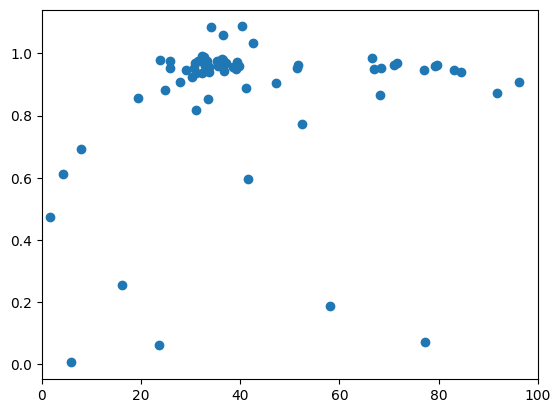

In [101]:
fig, ax = plt.subplots()

ax.scatter(final_scores[:, 0], final_scores[:, 1])

ax.set_xlim(0, 100)

In [103]:
final_scores_dict = {
    k: (v['unitarity_scores'][-1], v['overlap_scores'][-1])
    for k, v in results_dict.items()
}

In [107]:
sub_final_scores_dict = {
    k: (vu, vo) for k, (vu, vo) in final_scores_dict.items()
    if (vu < 40) and (vo > 0.5)
}

In [112]:
df = pd.DataFrame(list(sub_final_scores_dict.keys()))

In [113]:
df

,alpha,beta_1,beta_2,bond_dimension,num_sites,overlap_learning_rate
0,0.008169,0.362055,0.429223,8,2,265
1,0.008097,0.356802,0.436075,6,3,460
2,0.006779,0.342580,0.396110,5,3,57
3,0.002722,0.222031,0.237089,5,3,357
4,0.007962,0.412754,0.303152,4,3,202
5,0.000448,0.435836,0.278318,6,3,199
6,0.001473,0.238009,0.259752,8,3,484
7,0.000503,0.387064,0.424657,4,3,74
8,0.004570,0.246841,0.424926,8,3,405
9,0.004778,0.373594,0.351261,6,3,447


<Axes: >

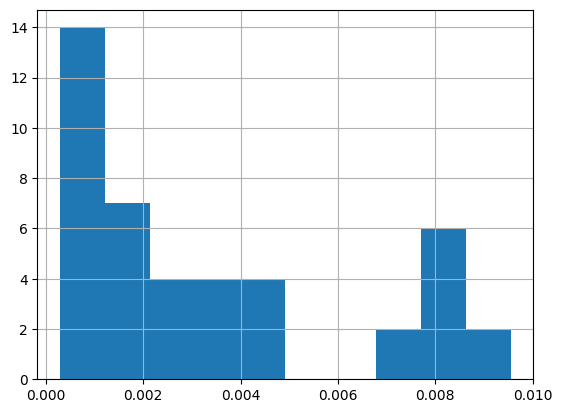

In [114]:
df['alpha'].hist()

<Axes: >

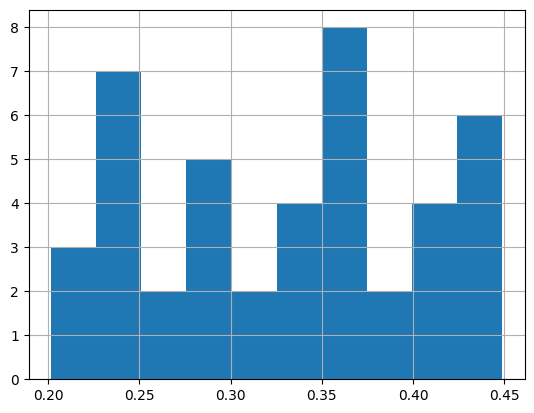

In [115]:
df['beta_1'].hist()

<Axes: >

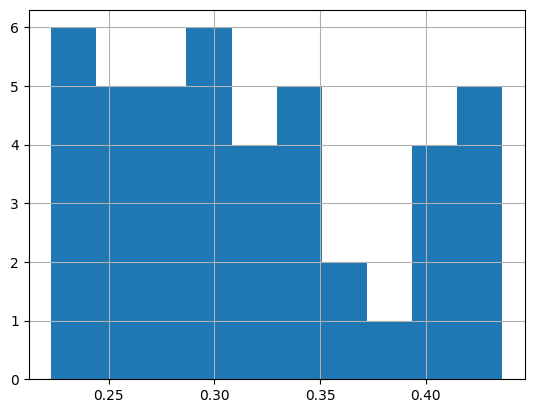

In [116]:
df['beta_2'].hist()

<Axes: >

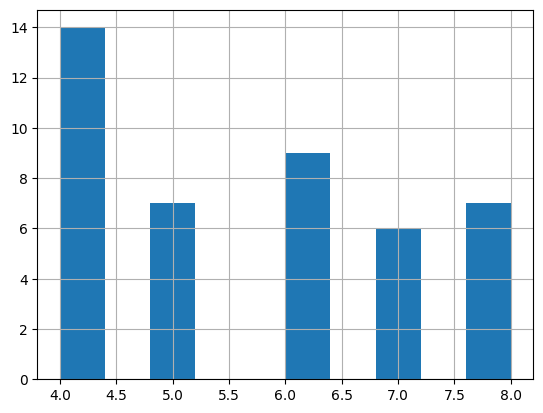

In [117]:
df['bond_dimension'].hist()

<Axes: >

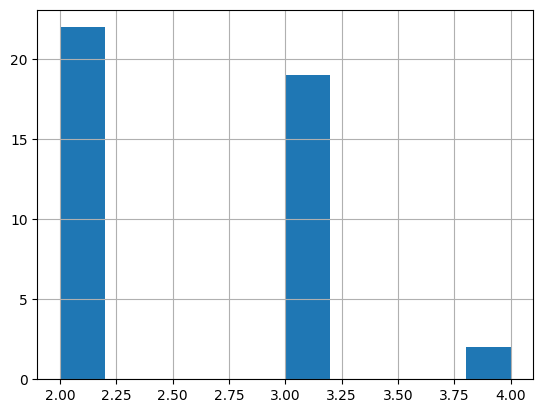

In [118]:
df['num_sites'].hist()

<Axes: >

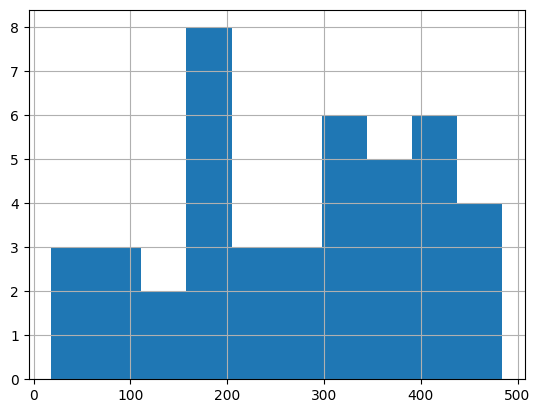

In [119]:
df['overlap_learning_rate'].hist()

## Round 2

In [122]:
hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 5e-3),
    'beta_1': scipy.stats.uniform(0.2, 0.25),
    'beta_2': scipy.stats.uniform(0.2, 0.2),
    'bond_dimension': scipy.stats.randint(4, 7),
    'num_sites': scipy.stats.randint(2, 6),
    'overlap_learning_rate': scipy.stats.randint(1, 500)
}

In [123]:
num_seeds = 100
num_iterations = 3000

In [124]:
results_dict_2 = dict()

In [125]:
for i in range(num_seeds):
    start = time.time()
    
    print(i)
    
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}
    print(hyperparams)

    (
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    ) = initialize_optimization(
        hyperparams['num_sites'],
        hyperparams['bond_dimension'],
        case,
        1, #Unitarity learning rate
        hyperparams['overlap_learning_rate'],
        (hyperparams['alpha'], hyperparams['beta_1'], hyperparams['beta_2'])
    )

    current_unitarity_scores = list()
    current_overlap_scores = list()

    j = 0
    should_continue = True
    while should_continue:
        unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
            left_mpo_tensors,
            right_mpo_tensors,
            left_b_tensors,
            right_b_tensors,
            left_total_dimension,
            right_total_dimension,
            unitarity_learning_rate,
            overlap_learning_rate,
            symmetry_transfer_matrix,
            left_adam_optimizers,
            right_adam_optimizers
        )

        current_unitarity_scores.append(unitarity)
        current_overlap_scores.append(overlap)

        j += 1
        should_continue = (
            (not early_stop(unitarity, overlap))
            and (j<num_iterations)
        )
    
    end = time.time()
    print(end - start)
    
    print(unitarity)
    print(overlap)

    print('')

    current_results = {
        'solutions': (left_mpo_tensors, right_mpo_tensors),
        'unitarity_scores': current_unitarity_scores,
        'overlap_scores': current_overlap_scores,
        'time': (end-start)
    }

    results_dict_2[HyperParams(**hyperparams)] = current_results

0
{'alpha': 0.00019834419017626727, 'beta_1': 0.3892792100974901, 'beta_2': 0.2510931732729043, 'bond_dimension': 4, 'num_sites': 5, 'overlap_learning_rate': 12}
155.21876096725464
(0.011929055087705365+1.7763568394002505e-14j)
0.009276353423181212

1
{'alpha': 0.002888348771385689, 'beta_1': 0.3401707045189113, 'beta_2': 0.34038429487993194, 'bond_dimension': 4, 'num_sites': 4, 'overlap_learning_rate': 411}
129.08852696418762
(45.97506474199088+2.913225216616411e-13j)
0.9411842549064842

2
{'alpha': 0.0008328623899188717, 'beta_1': 0.2160847052718959, 'beta_2': 0.28505613893947257, 'bond_dimension': 6, 'num_sites': 4, 'overlap_learning_rate': 20}
169.11818194389343
(3.2158201388279366-9.50350909079134e-14j)
0.5547049892525513

3
{'alpha': 0.00014648041631329319, 'beta_1': 0.20424619408800412, 'beta_2': 0.36261773532536173, 'bond_dimension': 4, 'num_sites': 3, 'overlap_learning_rate': 289}
91.42038202285767
(104.16778062117828-5.329070518200751e-15j)
0.23479638115520812

4
{'alpha': 0.

KeyboardInterrupt: 

In [126]:
len(results_dict_2)

54

In [127]:
final_scores = np.array([
    (v['unitarity_scores'][-1], v['overlap_scores'][-1])
    for v in results_dict_2.values()
])

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


(0.0, 100.0)

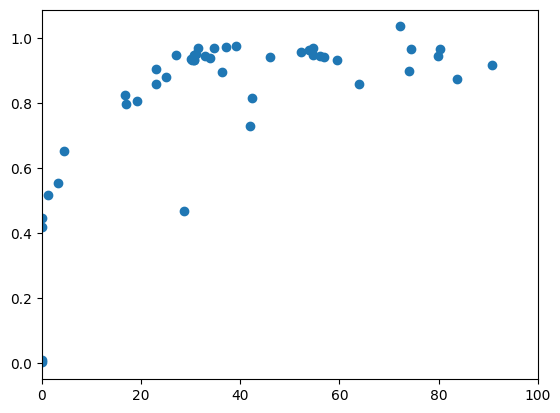

In [128]:
fig, ax = plt.subplots()

ax.scatter(final_scores[:, 0], final_scores[:, 1])

ax.set_xlim(0, 100)

In [129]:
final_scores_dict = {
    k: (v['unitarity_scores'][-1], v['overlap_scores'][-1])
    for k, v in results_dict_2.items()
}

In [130]:
sub_final_scores_dict = {
    k: (vu, vo) for k, (vu, vo) in final_scores_dict.items()
    if (vu < 40) and (vo > 0.5)
}

In [131]:
df = pd.DataFrame(list(sub_final_scores_dict.keys()))

In [132]:
df

,alpha,beta_1,beta_2,bond_dimension,num_sites,overlap_learning_rate
0,0.000833,0.216085,0.285056,6,4,20
1,0.000592,0.403012,0.316335,6,3,193
2,0.000441,0.320707,0.368794,6,4,72
3,0.000430,0.423236,0.390629,5,2,301
4,0.000260,0.348314,0.329866,6,3,306
5,0.000914,0.423209,0.353690,6,2,131
6,0.000310,0.251527,0.277475,5,2,44
7,0.000356,0.333128,0.211976,5,4,157
8,0.004703,0.268567,0.221332,5,4,399
9,0.000414,0.218147,0.231984,6,4,211


<Axes: >

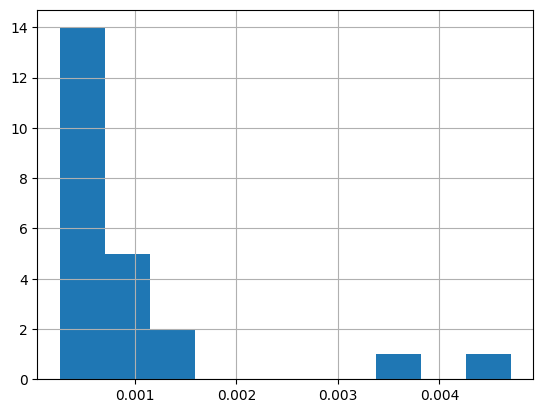

In [133]:
df['alpha'].hist()

<Axes: >

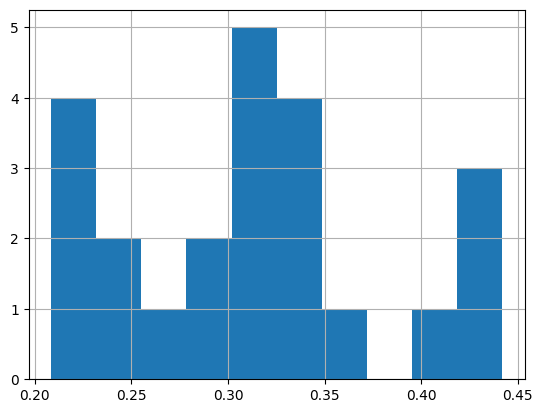

In [134]:
df['beta_1'].hist()

<Axes: >

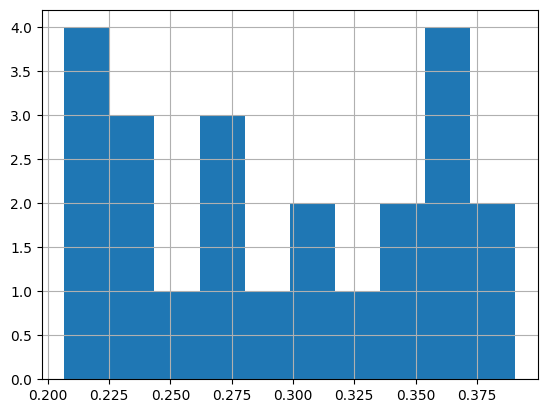

In [135]:
df['beta_2'].hist()

<Axes: >

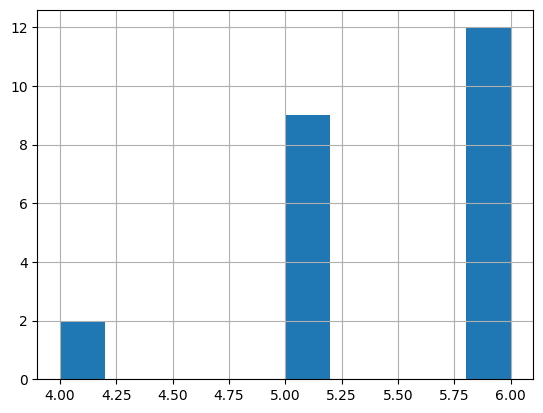

In [136]:
df['bond_dimension'].hist()

<Axes: >

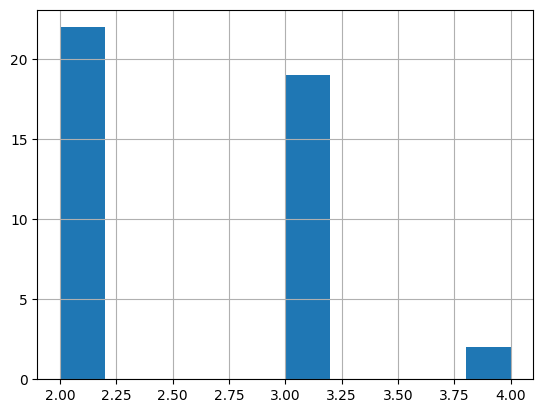

In [118]:
df['num_sites'].hist()

<Axes: >

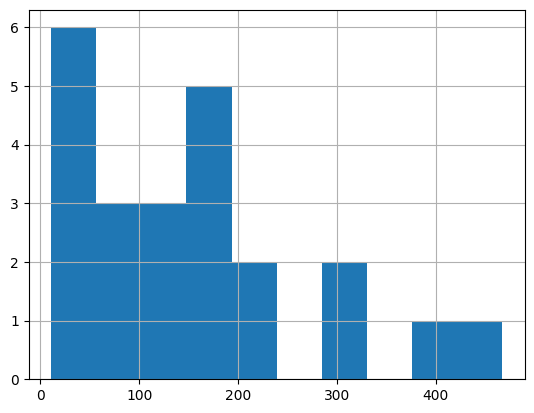

In [137]:
df['overlap_learning_rate'].hist()

## Round 3

In [138]:
hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-3),
    'beta_1': scipy.stats.uniform(0.2, 0.25),
    'beta_2': scipy.stats.uniform(0.2, 0.2),
    'bond_dimension': scipy.stats.randint(4, 7),
    'num_sites': scipy.stats.randint(3, 7),
    'overlap_learning_rate': scipy.stats.randint(1, 200)
}

In [139]:
num_seeds = 100
num_iterations = 3000

In [140]:
results_dict_3 = dict()

In [141]:
for i in range(num_seeds):
    start = time.time()
    
    print(i)
    
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}
    print(hyperparams)

    (
        left_mpo_tensors,
        right_mpo_tensors,
        left_b_tensors,
        right_b_tensors,
        left_total_dimension,
        right_total_dimension,
        unitarity_learning_rate,
        overlap_learning_rate,
        symmetry_transfer_matrix,
        left_adam_optimizers,
        right_adam_optimizers
    ) = initialize_optimization(
        hyperparams['num_sites'],
        hyperparams['bond_dimension'],
        case,
        1, #Unitarity learning rate
        hyperparams['overlap_learning_rate'],
        (hyperparams['alpha'], hyperparams['beta_1'], hyperparams['beta_2'])
    )

    current_unitarity_scores = list()
    current_overlap_scores = list()

    j = 0
    should_continue = True
    while should_continue:
        unitarity, overlap = two_sided_mpo_gradient_descent_sweep(
            left_mpo_tensors,
            right_mpo_tensors,
            left_b_tensors,
            right_b_tensors,
            left_total_dimension,
            right_total_dimension,
            unitarity_learning_rate,
            overlap_learning_rate,
            symmetry_transfer_matrix,
            left_adam_optimizers,
            right_adam_optimizers
        )

        current_unitarity_scores.append(unitarity)
        current_overlap_scores.append(overlap)

        j += 1
        should_continue = (
            (not early_stop(unitarity, overlap))
            and (j<num_iterations)
        )
    
    end = time.time()
    print(end - start)
    
    print(unitarity)
    print(overlap)

    print('')

    current_results = {
        'solutions': (left_mpo_tensors, right_mpo_tensors),
        'unitarity_scores': current_unitarity_scores,
        'overlap_scores': current_overlap_scores,
        'time': (end-start)
    }

    results_dict_3[HyperParams(**hyperparams)] = current_results

0
{'alpha': 0.0007835518598268001, 'beta_1': 0.40018147772221746, 'beta_2': 0.3603716791268629, 'bond_dimension': 6, 'num_sites': 5, 'overlap_learning_rate': 55}
186.8914668560028
(33.90104817770333-2.7959856652159942e-12j)
0.6620800611402299

1
{'alpha': 0.00035921101740904926, 'beta_1': 0.3292609370384136, 'beta_2': 0.3655322363815182, 'bond_dimension': 5, 'num_sites': 6, 'overlap_learning_rate': 95}
232.0060076713562
(0.019971917426914843-4.8405723873656825e-14j)
0.00023648704267905762

2
{'alpha': 0.00015170274890903795, 'beta_1': 0.21301137141809423, 'beta_2': 0.33403730463932946, 'bond_dimension': 5, 'num_sites': 5, 'overlap_learning_rate': 21}
163.98195219039917
(3.344753150957729+1.3322676295501878e-14j)
0.0012105592856369127

3
{'alpha': 0.00012934962632459365, 'beta_1': 0.272872350608056, 'beta_2': 0.30421283007717304, 'bond_dimension': 5, 'num_sites': 5, 'overlap_learning_rate': 117}
184.01057195663452
(2.321541649727351+4.440892098500626e-14j)
0.010571691912651357

4
{'alph

KeyboardInterrupt: 

In [142]:
len(results_dict_3)

21

In [143]:
final_scores = np.array([
    (v['unitarity_scores'][-1], v['overlap_scores'][-1])
    for v in results_dict_3.values()
])

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


(0.0, 100.0)

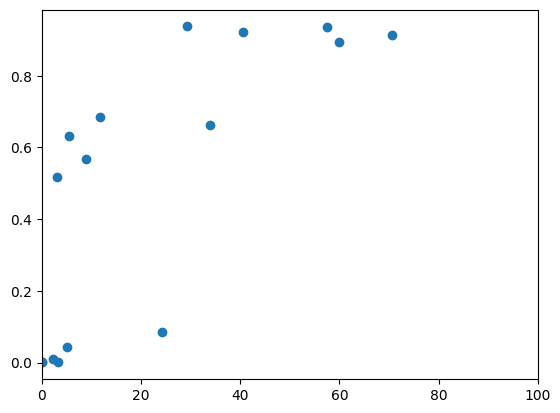

In [144]:
fig, ax = plt.subplots()

ax.scatter(final_scores[:, 0], final_scores[:, 1])

ax.set_xlim(0, 100)

In [145]:
final_scores_dict = {
    k: (v['unitarity_scores'][-1], v['overlap_scores'][-1])
    for k, v in results_dict_2.items()
}

In [146]:
sub_final_scores_dict = {
    k: (vu, vo) for k, (vu, vo) in final_scores_dict.items()
    if (vu < 40) and (vo > 0.5)
}

In [147]:
df = pd.DataFrame(list(sub_final_scores_dict.keys()))

In [148]:
df

,alpha,beta_1,beta_2,bond_dimension,num_sites,overlap_learning_rate
0,0.000833,0.216085,0.285056,6,4,20
1,0.000592,0.403012,0.316335,6,3,193
2,0.000441,0.320707,0.368794,6,4,72
3,0.000430,0.423236,0.390629,5,2,301
4,0.000260,0.348314,0.329866,6,3,306
5,0.000914,0.423209,0.353690,6,2,131
6,0.000310,0.251527,0.277475,5,2,44
7,0.000356,0.333128,0.211976,5,4,157
8,0.004703,0.268567,0.221332,5,4,399
9,0.000414,0.218147,0.231984,6,4,211


<Axes: >

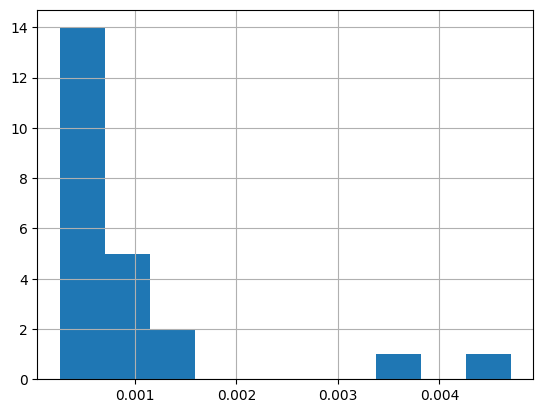

In [133]:
df['alpha'].hist()

<Axes: >

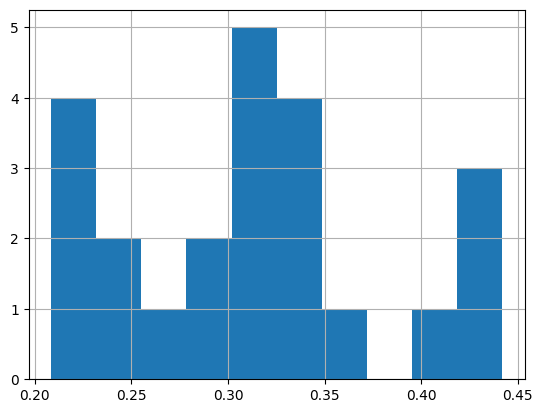

In [134]:
df['beta_1'].hist()

<Axes: >

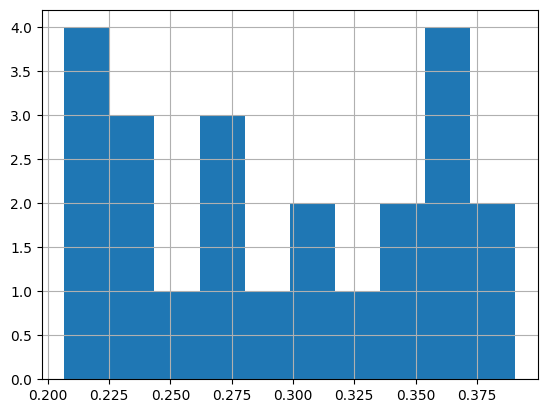

In [135]:
df['beta_2'].hist()

<Axes: >

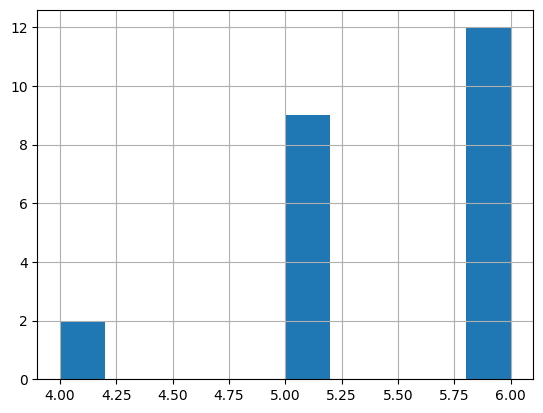

In [136]:
df['bond_dimension'].hist()

<Axes: >

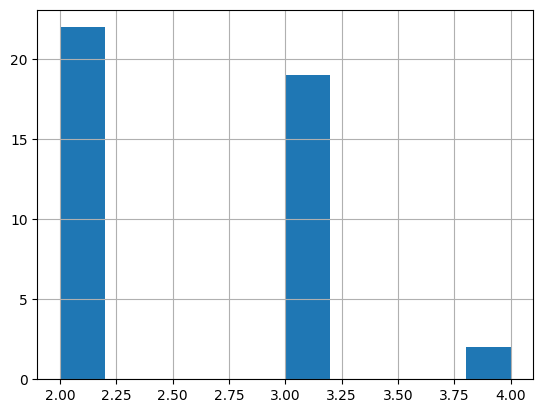

In [118]:
df['num_sites'].hist()

<Axes: >

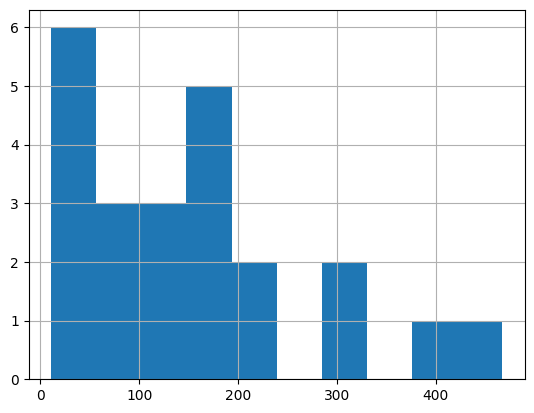

In [137]:
df['overlap_learning_rate'].hist()